In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy.linalg import cholesky, lstsq


In [46]:
from experiments import MoreTraceGases, Sensors
from experiments import utilities as utils
from bayesinverse import Regression
from robiplotipy import PlotEnv
import robiplotipy.experiments.more_trace_gases as plt_exp

In [47]:
config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/more_trace_gases/config.yaml"
)

exp = MoreTraceGases(config_path)
# basic_setup.run()


sensors 0.0031067728996276855
emissions 1.5751794576644897
transport 4.170622676610947


In [48]:
plot_env = PlotEnv(
    fig_path="/home/rmaiwald/results/plotting/more_trace_gases/",
    logging=True,
    display=True,
)


In [49]:
exp.sensors_config

{'n_sensors': 10, 'height': 0, 'noise': 1.0, 'seed': 2, 'time': 24}

In [50]:
# CO2 sensors
exp.sensors_co2 = Sensors(exp.sensors_config)

# CO sensors
co_config = exp.sensors_config
co_config["noise"] = .01
co_config["seed"] = 5
exp.sensors_co = Sensors(exp.sensors_config)

In [51]:
em_factors_co = exp.emissions.get_emission_factors()[exp.emissions.mask]
em_factors = xr.DataArray(em_factors_co, dims=["source_group"])

In [52]:
exp.load_data()
posterior = exp.data["posterior"]
posterior_combined = exp.data["posterior_combined"]
posterior_covariance = exp.data["posterior_covariance"]
posterior_combined_covariance = exp.data["posterior_combined_covariance"]

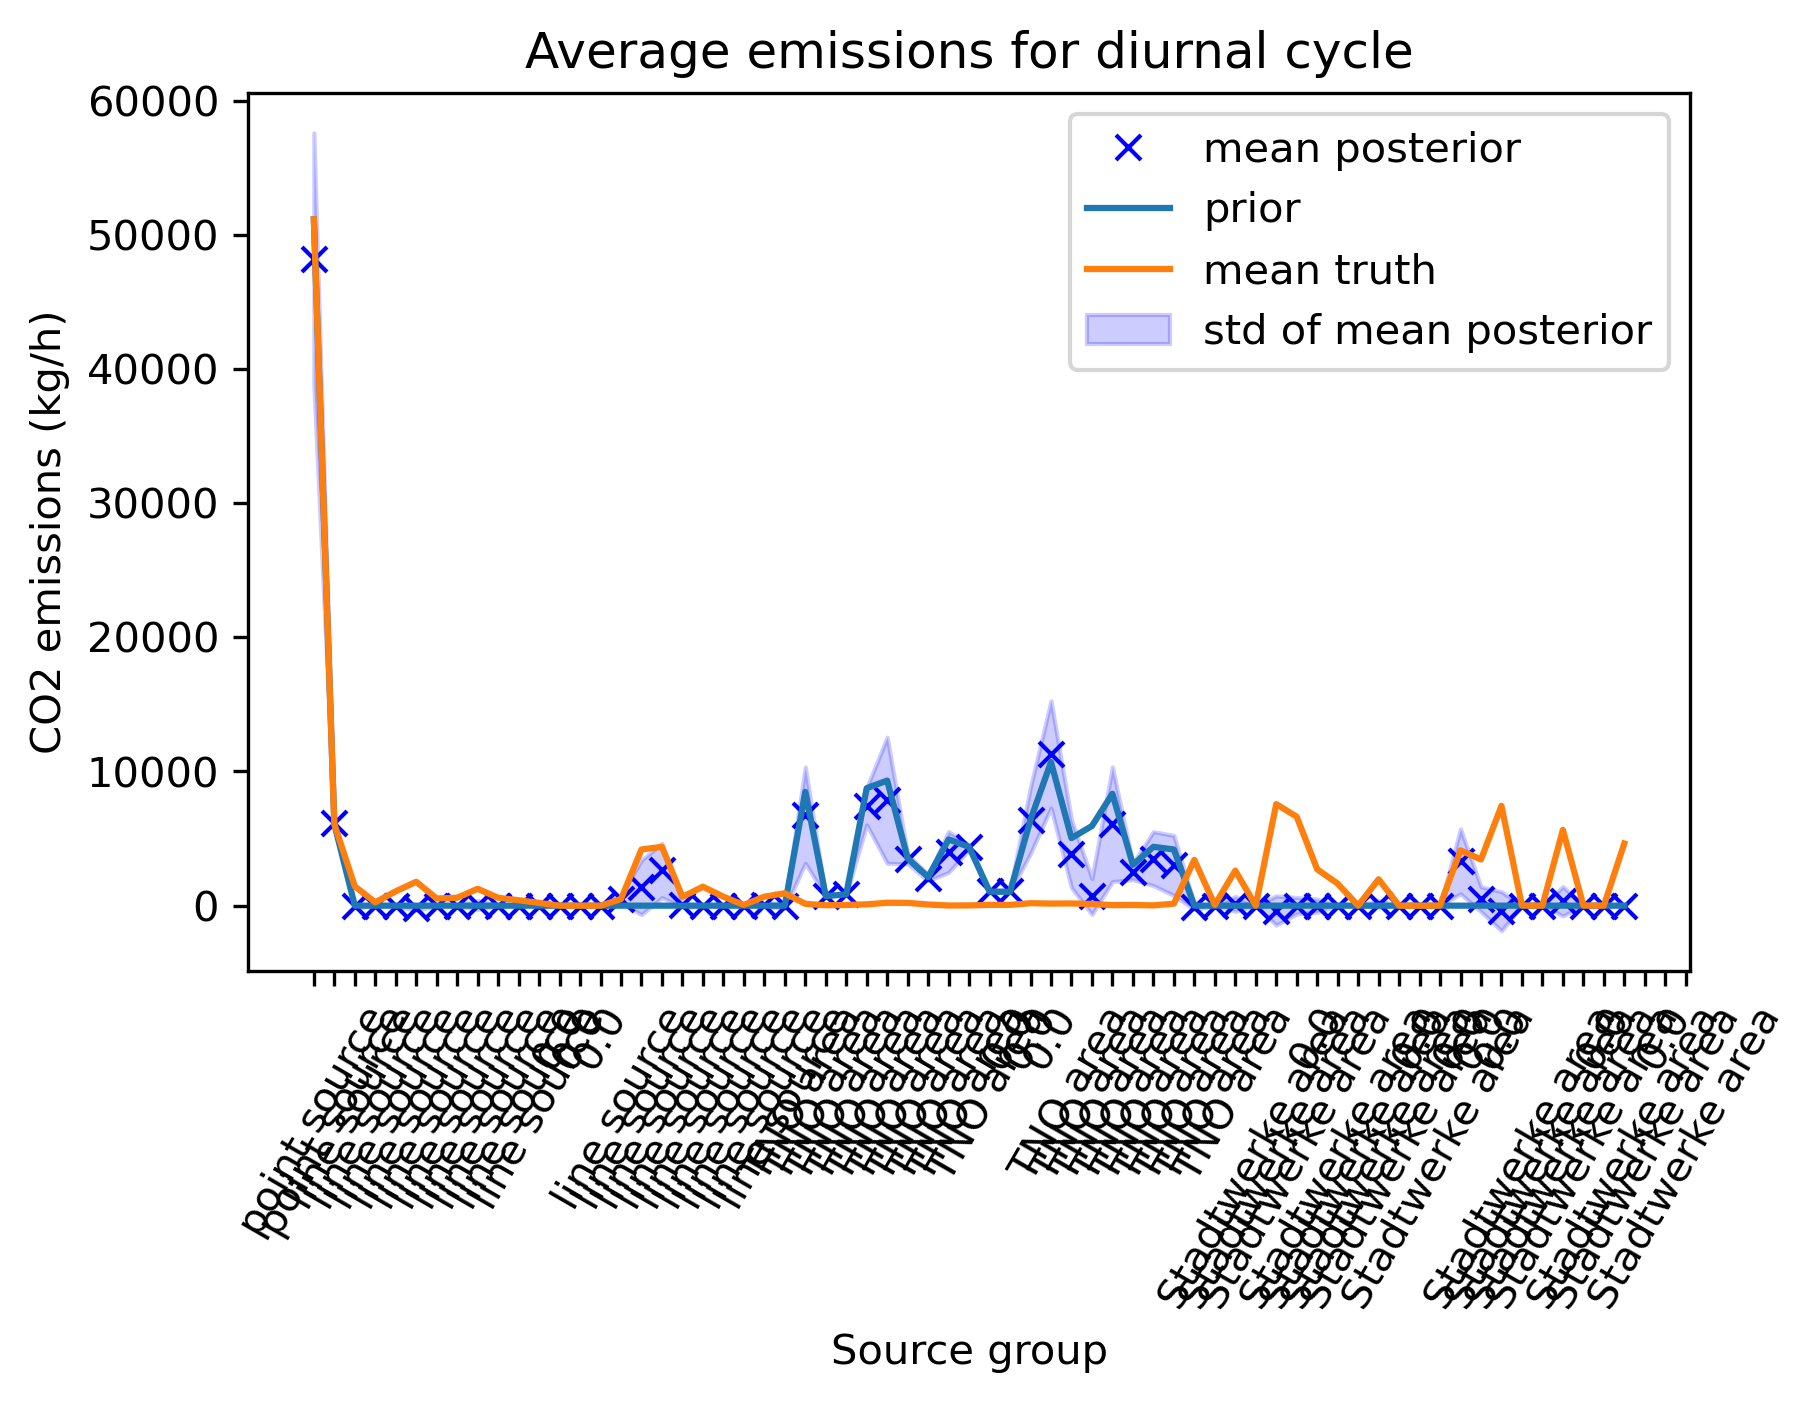

In [53]:
mean = utils.unstack_xr(posterior).mean("time_state")
std = utils.unstack_xr(posterior).std("time_state")
line = plt.plot(mean, "bx", label="mean posterior")[0]
plt.fill_between(
    range(len(mean)),
    mean - std,
    mean + std,
    alpha=0.2,
    color=line._color,
    label="std of mean posterior",
)

plt.plot(exp.emissions.prior_absolute.mean("time_state"), label="prior")
plt.plot(exp.emissions.truth_absolute.mean("time_state"), label="mean truth")
plt.xlabel("Source group")
plt.ylabel("CO2 emissions (kg/h)")
plt.legend()
ticks = list(exp.emissions.source_group_df["source_type"].values)
plt.xticks(np.arange(len(ticks)), ticks, rotation=60)
plt.title("Average emissions for diurnal cycle")
pass


In [54]:
point_index = exp.emissions.source_group_df.query("source_type == 'point source'").index
traffic_index = exp.emissions.source_group_df.query("source_type == 'line source'").index
tno_area_index = exp.emissions.source_group_df.query("source_type == 'TNO area'").index
heating_index = exp.emissions.source_group_df.query("source_type == 'Stadtwerke area'").index
valid_index = exp.emissions.source_group_df.query("source_type != '0.0'").index

All sources

In [55]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=valid_index,
)
y_label = r"Total CO$_2$ emissions (kg/h)"

In [56]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 25357.134167819986
RMSE: 28829.28338910312


[Errno 17] File exists: '/home/rmaiwald/results/plotting/more_trace_gases/total/config_log.yml'


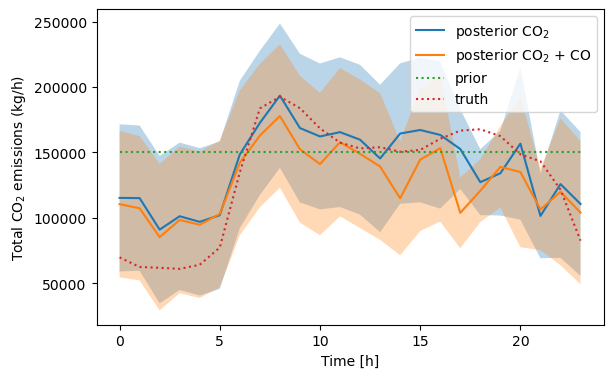

In [57]:
with plot_env(name="total", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Without points

In [58]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=valid_index[2:],
)
y_label = r"Total CO$_2$ emissions without point sources (kg/h)"

In [59]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 17136.937746557527
RMSE: 15949.713087190852


[Errno 17] File exists: '/home/rmaiwald/results/plotting/more_trace_gases/without_points/config_log.yml'


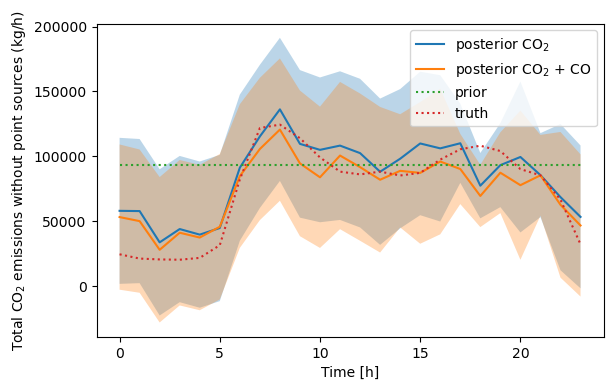

In [60]:
with plot_env(name="without_points", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Points

In [61]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=point_index,
)
y_label = r"Total CO$_2$ emissions without point sources (kg/h)"

In [62]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 13942.771617751789
RMSE: 17631.70933710592


[Errno 17] File exists: '/home/rmaiwald/results/plotting/more_trace_gases/points/config_log.yml'


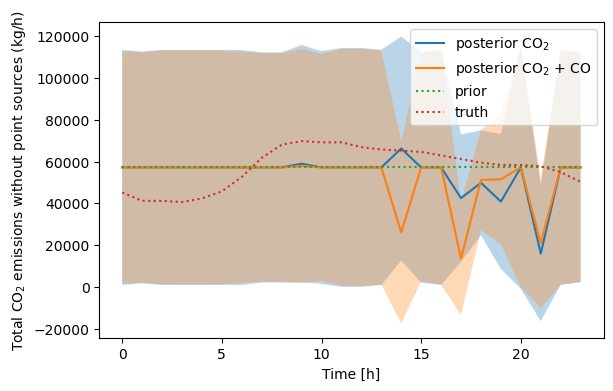

In [63]:
with plot_env(name="points", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Traffic

In [64]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=traffic_index,
)
y_label = r"Total CO$_2$ emissions from traffic (kg/h)"

In [65]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 20253.19877200529
RMSE: 11683.0754025575


[Errno 17] File exists: '/home/rmaiwald/results/plotting/more_trace_gases/traffic/config_log.yml'


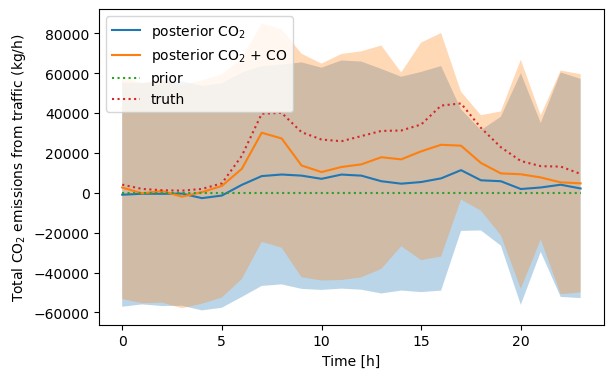

In [66]:
with plot_env(name="traffic", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

Heating

In [67]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=heating_index,
)
y_label = r"Total CO$_2$ emissions from stationary combustion (kg/h)"

In [68]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 51786.27958315792
RMSE: 52383.97551097262


[Errno 17] File exists: '/home/rmaiwald/results/plotting/more_trace_gases/heating/config_log.yml'


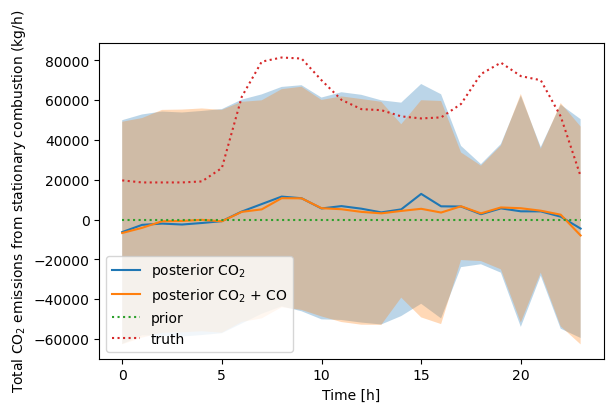

In [69]:
with plot_env(name="heating", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
        )

TNO area sources

In [70]:
time, sum_0, std_0, sum_1, std_1, sum_prior, sum_truth = utils.get_plotting_params(
    exp=exp,
    posterior_0=posterior,
    posterior_covariance_0=posterior_covariance,
    posterior_1=posterior_combined,
    posterior_covariance_1=posterior_combined_covariance,
    index=tno_area_index,
)
y_label = r"Total CO$_2$ emissions from TNO area sources (kg/h)"

In [71]:
print("RMSE: {}".format(utils.compute_rmse(sum_0, sum_truth).values))
print("RMSE: {}".format(utils.compute_rmse(sum_1, sum_truth).values))

RMSE: 77518.56273986574
RMSE: 60445.34823005825


[Errno 17] File exists: '/home/rmaiwald/results/plotting/more_trace_gases/TNO area sources/config_log.yml'


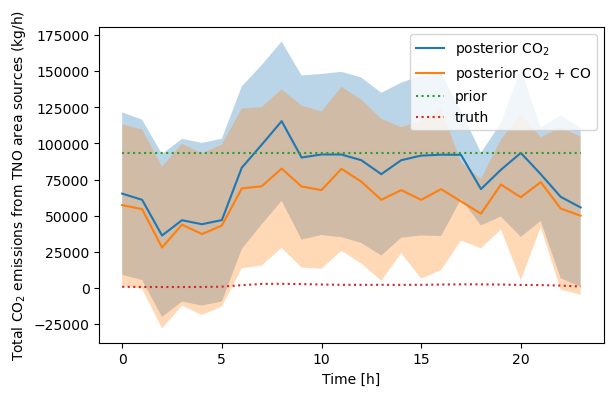

In [72]:
with plot_env(name="TNO area sources", notes=exp.config):
    plt_exp.plot_time_series(
        env=plot_env,
        time=time,
        mean_0=sum_0,
        std_0=std_0,
        mean_1=sum_1,
        std_1=std_1,
        mean_prior=sum_prior,
        mean_truth=sum_truth,
        y_label=y_label,
    )

In [73]:
var = []
for coor, sub_arr in posterior_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var.append(utils.var_of_sum(cov))

In [74]:
var_combined = []
for coor, sub_arr in posterior_combined_covariance.groupby('time_state'):
    cov = sub_arr.sel(time_state_2=coor).isel(source_group=slice(1, None))
    var_combined.append(utils.var_of_sum(cov))

RMSE: <xarray.DataArray ()>
array(28915.53231995)
RMSE with CO: <xarray.DataArray ()>
array(29598.99908415)


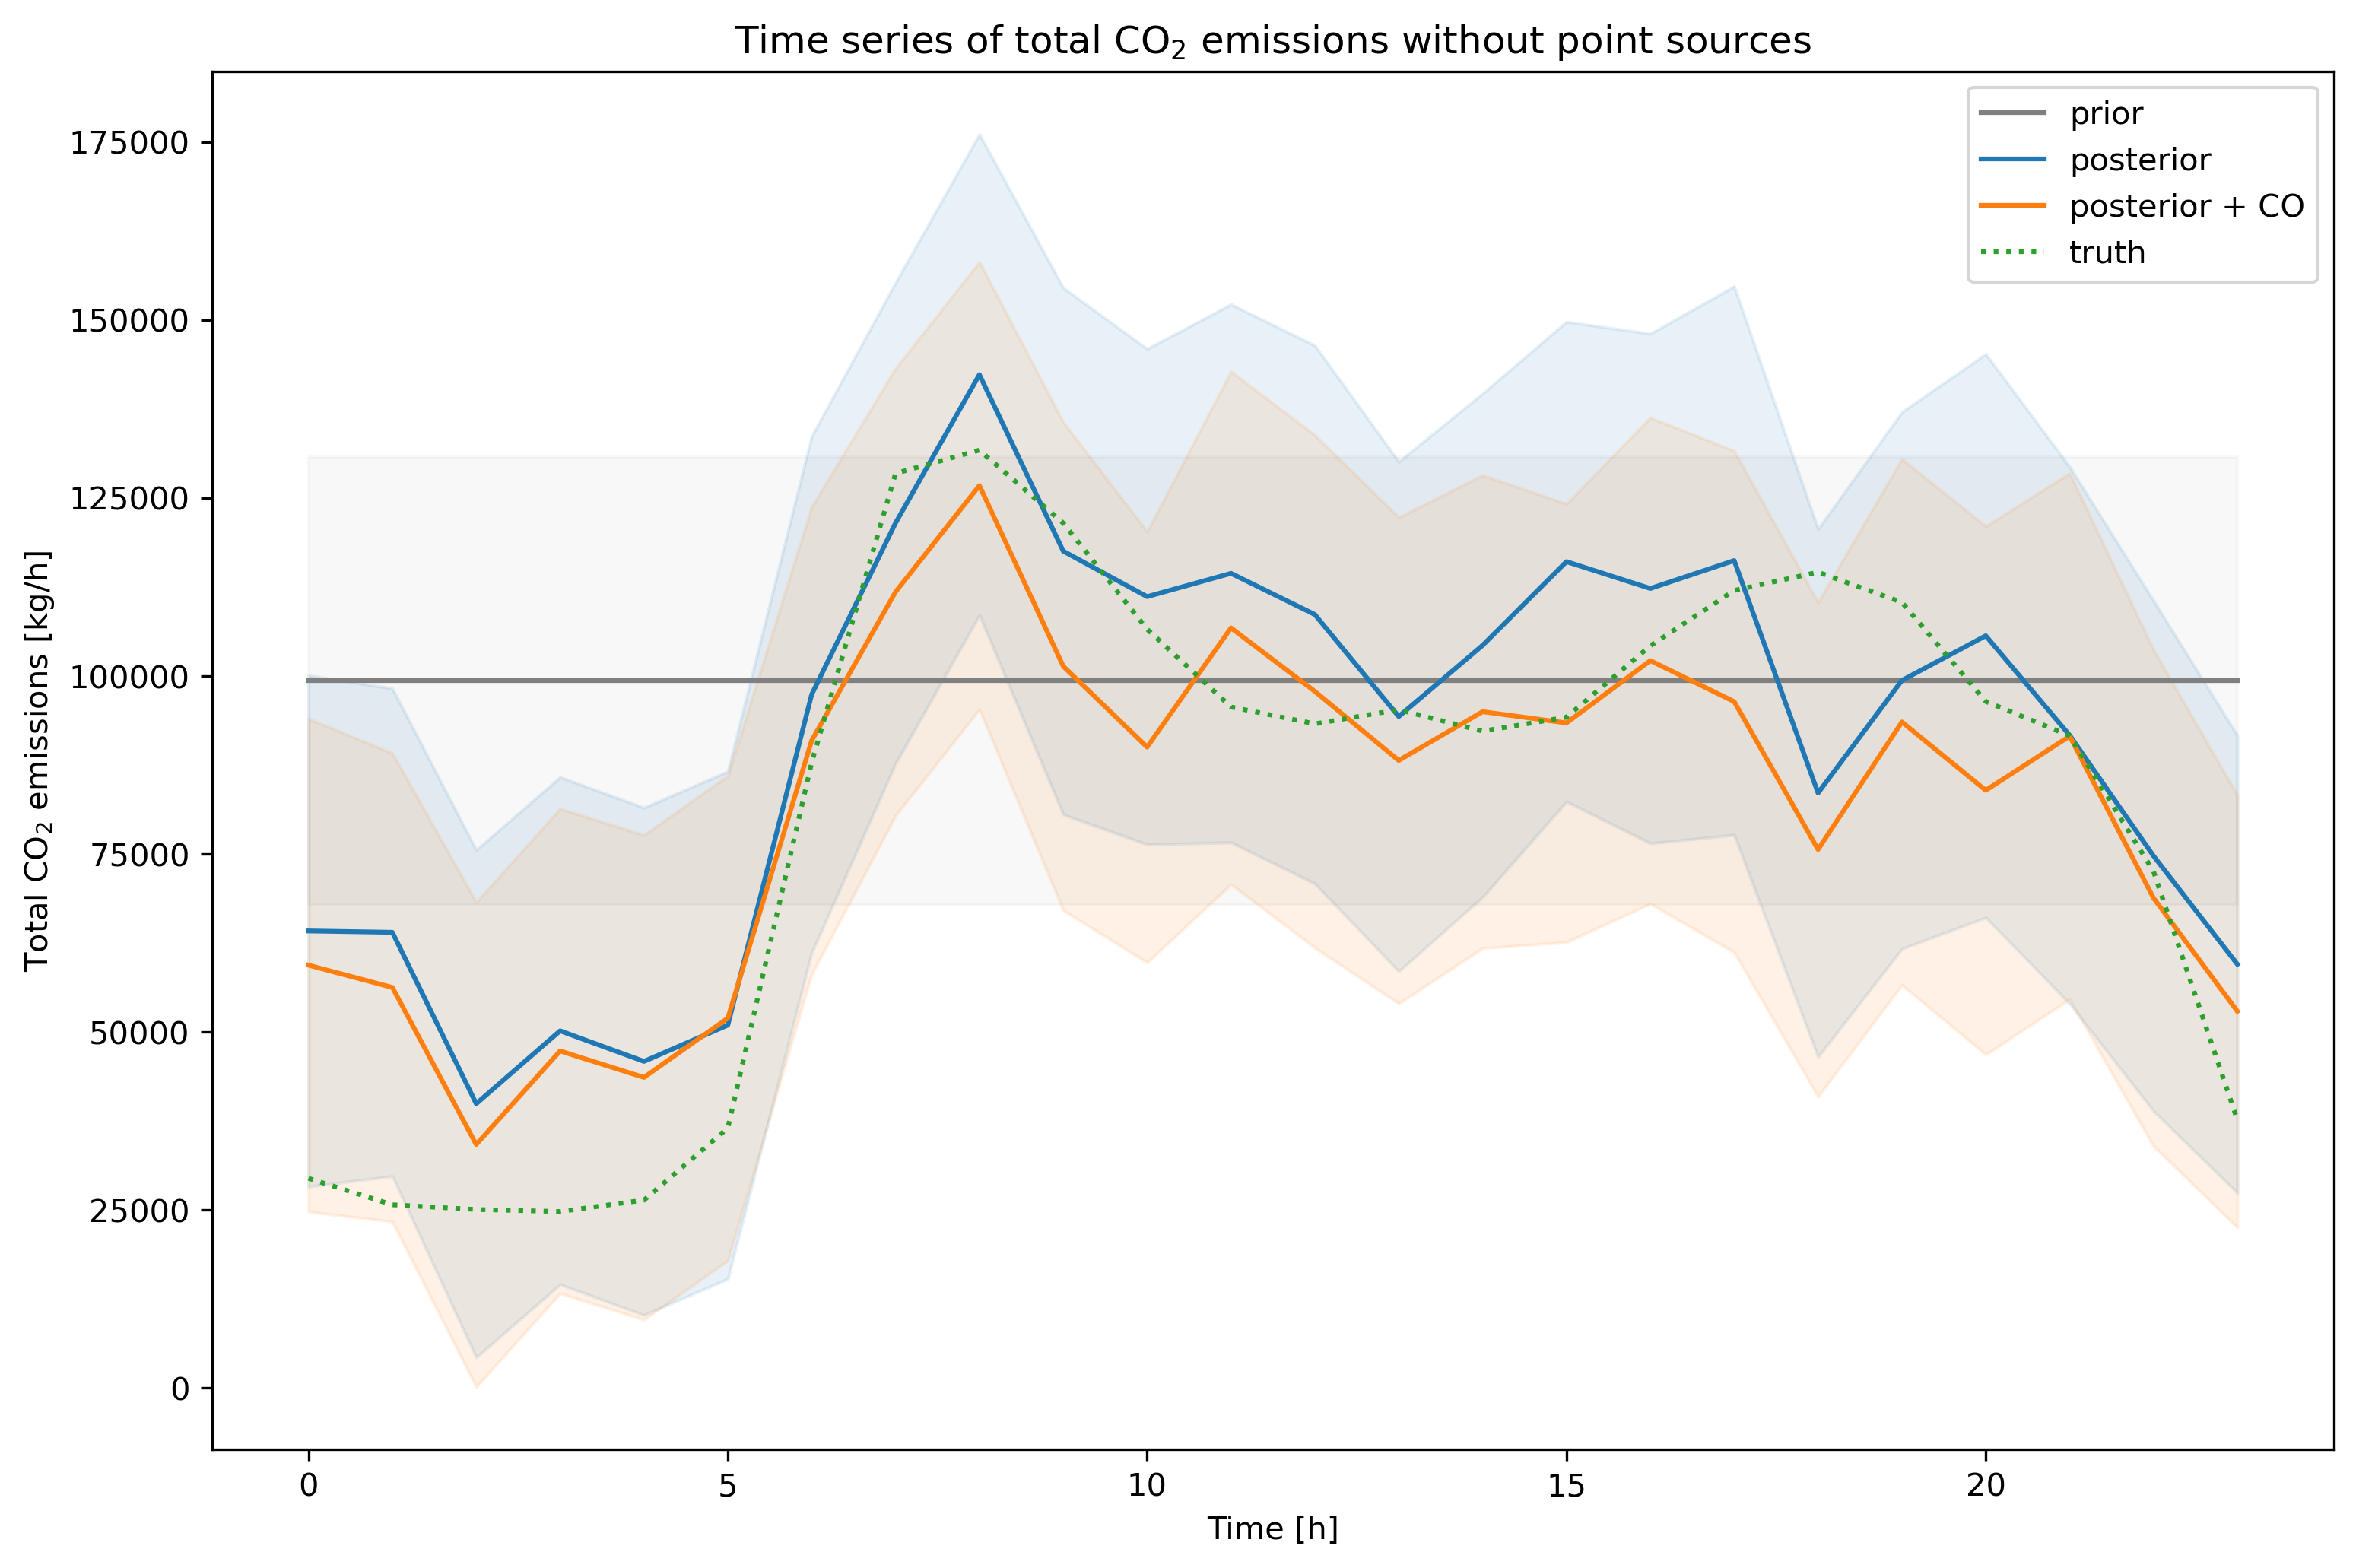

In [75]:
plt.figure(figsize=(12, 8))

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.05,
    color=line._color,
)

mean = posterior.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
rmse = np.sqrt(np.mean((mean - mean_prior)**2))
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)

mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
rmse_co = np.sqrt(np.mean((mean - mean_prior)**2))
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1, color=line._color)


plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions without point sources")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig(
    "/home/rmaiwald/results/preliminary/more_trace_gases_timeseries_no_point_sources"
)
print("RMSE: {}".format(rmse))
print("RMSE with CO: {}".format(rmse_co))

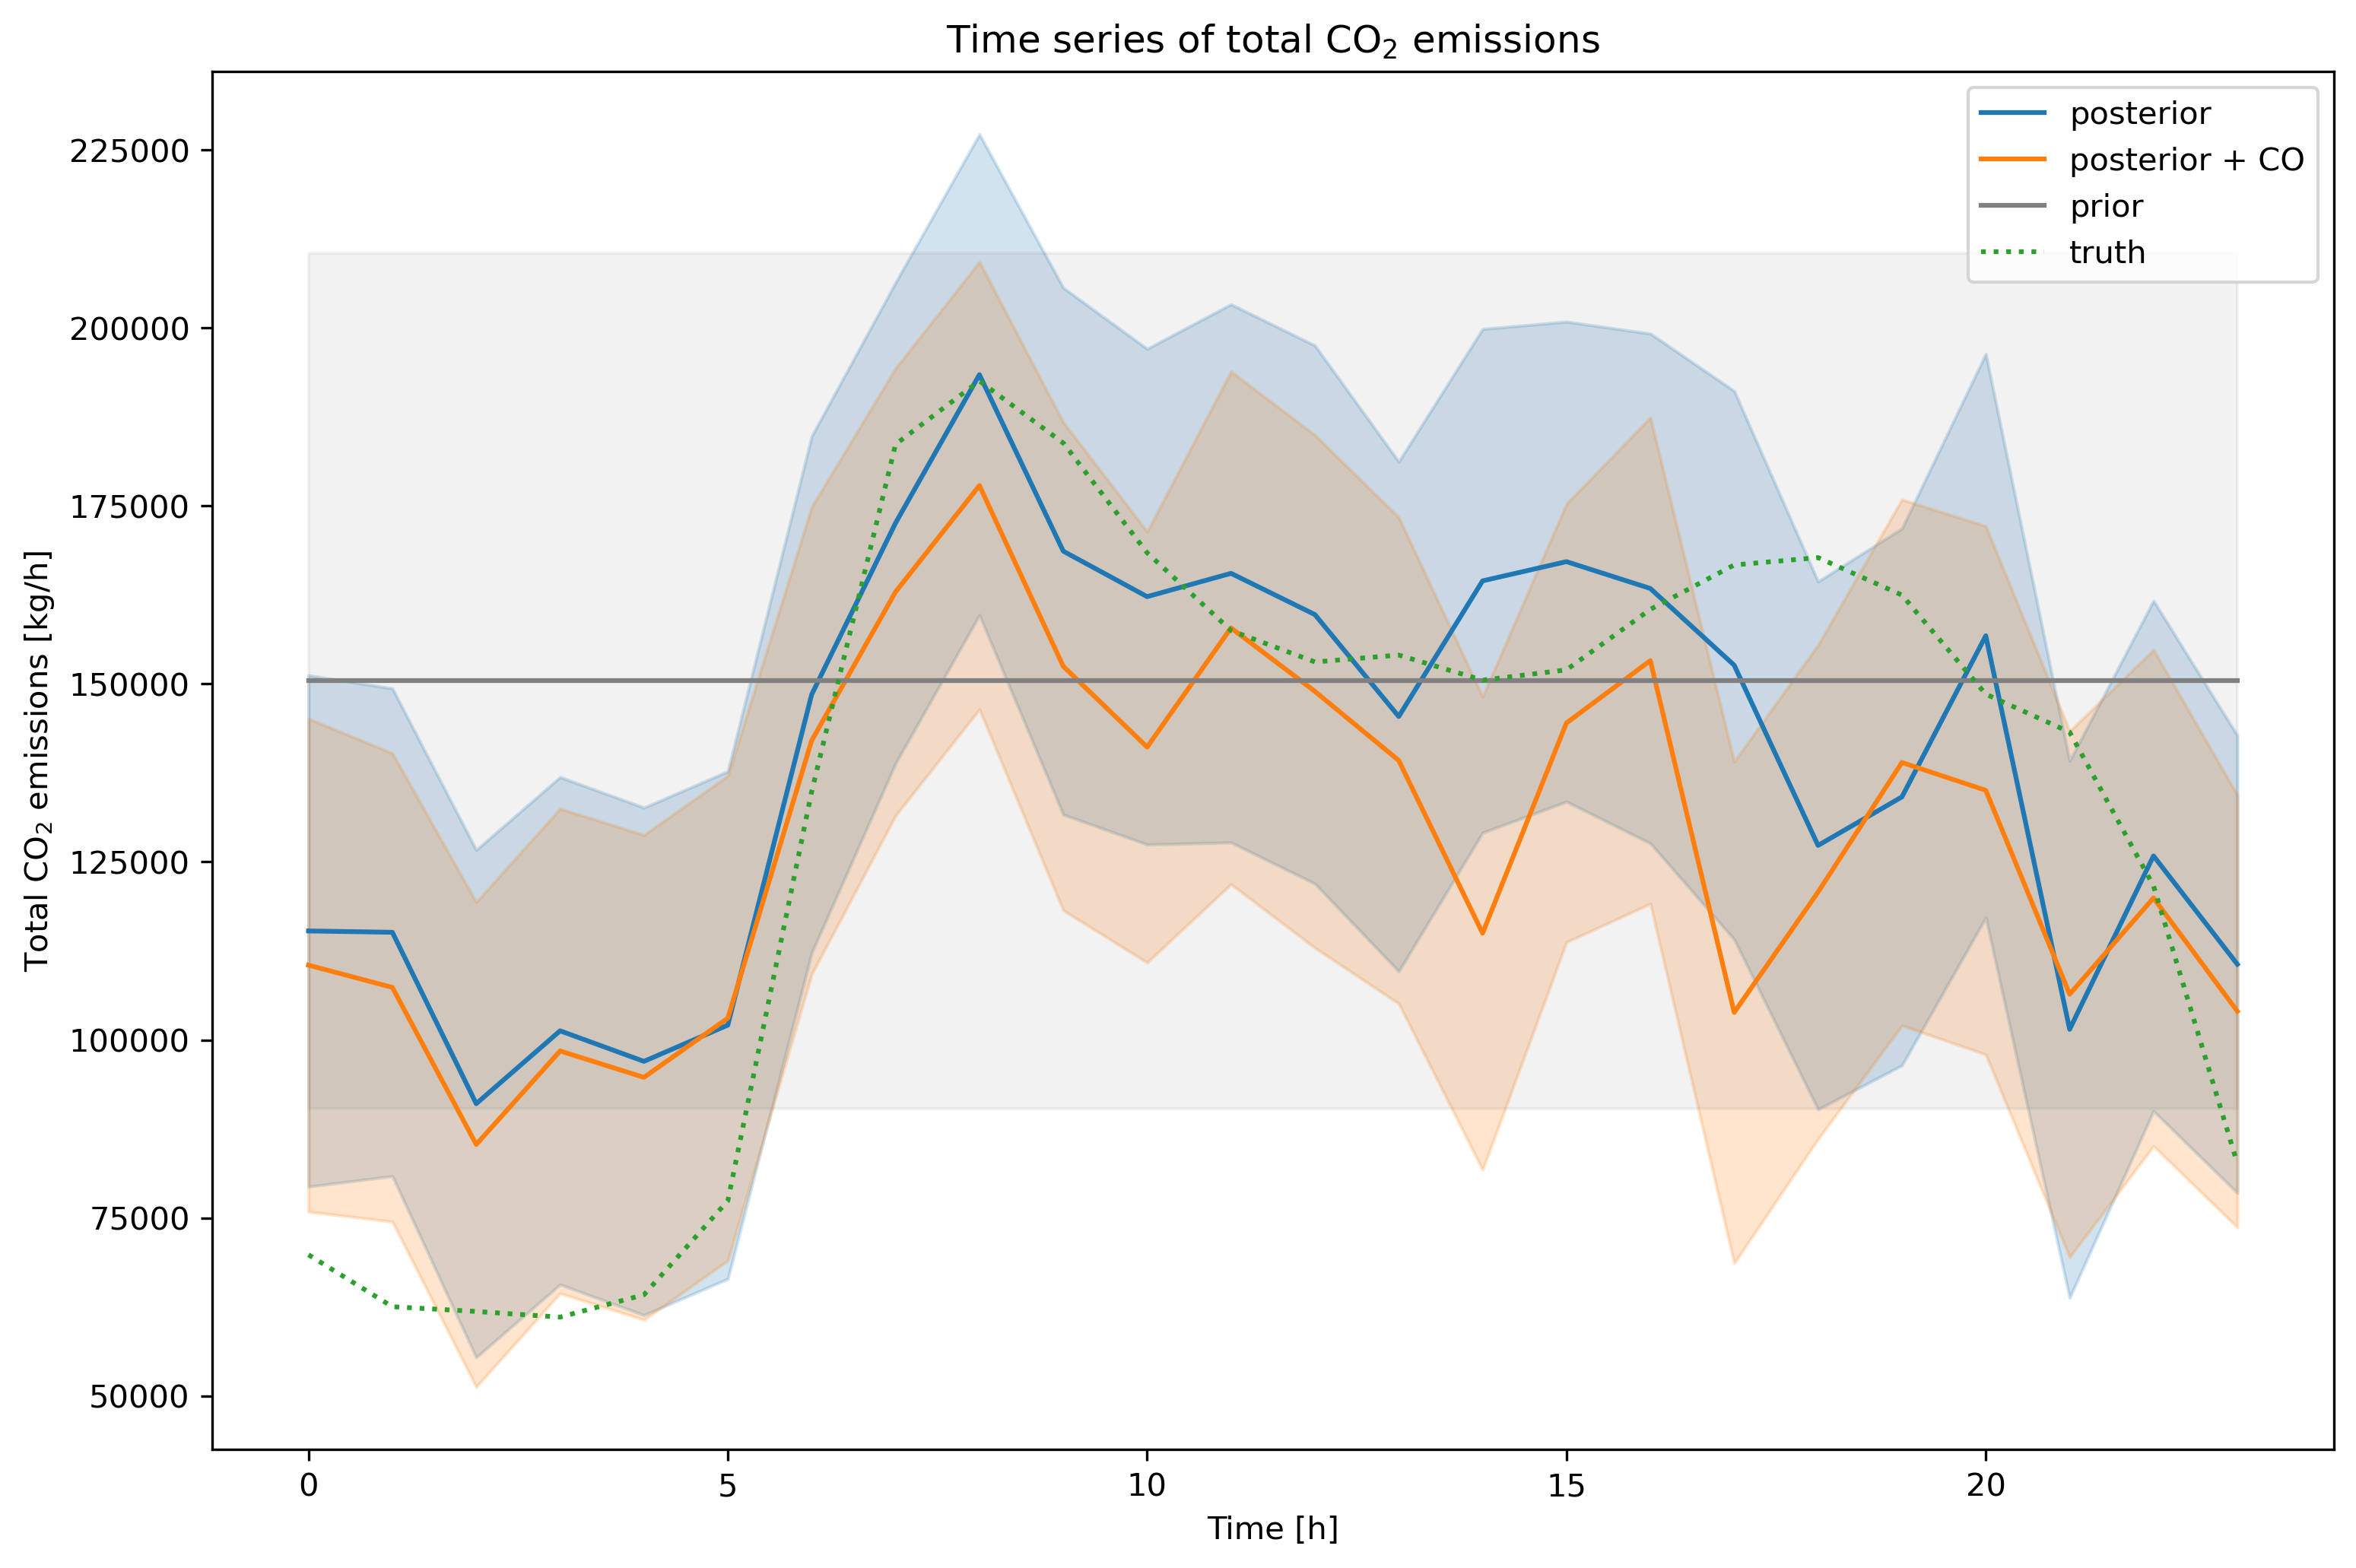

In [76]:
plt.figure(figsize=(12, 8))
mean = posterior.sum("source_group")
std = np.sqrt(var)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean = posterior_combined.sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior + CO")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, color="grey", label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.1,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
# print((mean - mean_prior).mean())
plt.title(r"Time series of total CO$_2$ emissions")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")

<xarray.DataArray ()>
array(-17651.48670963)


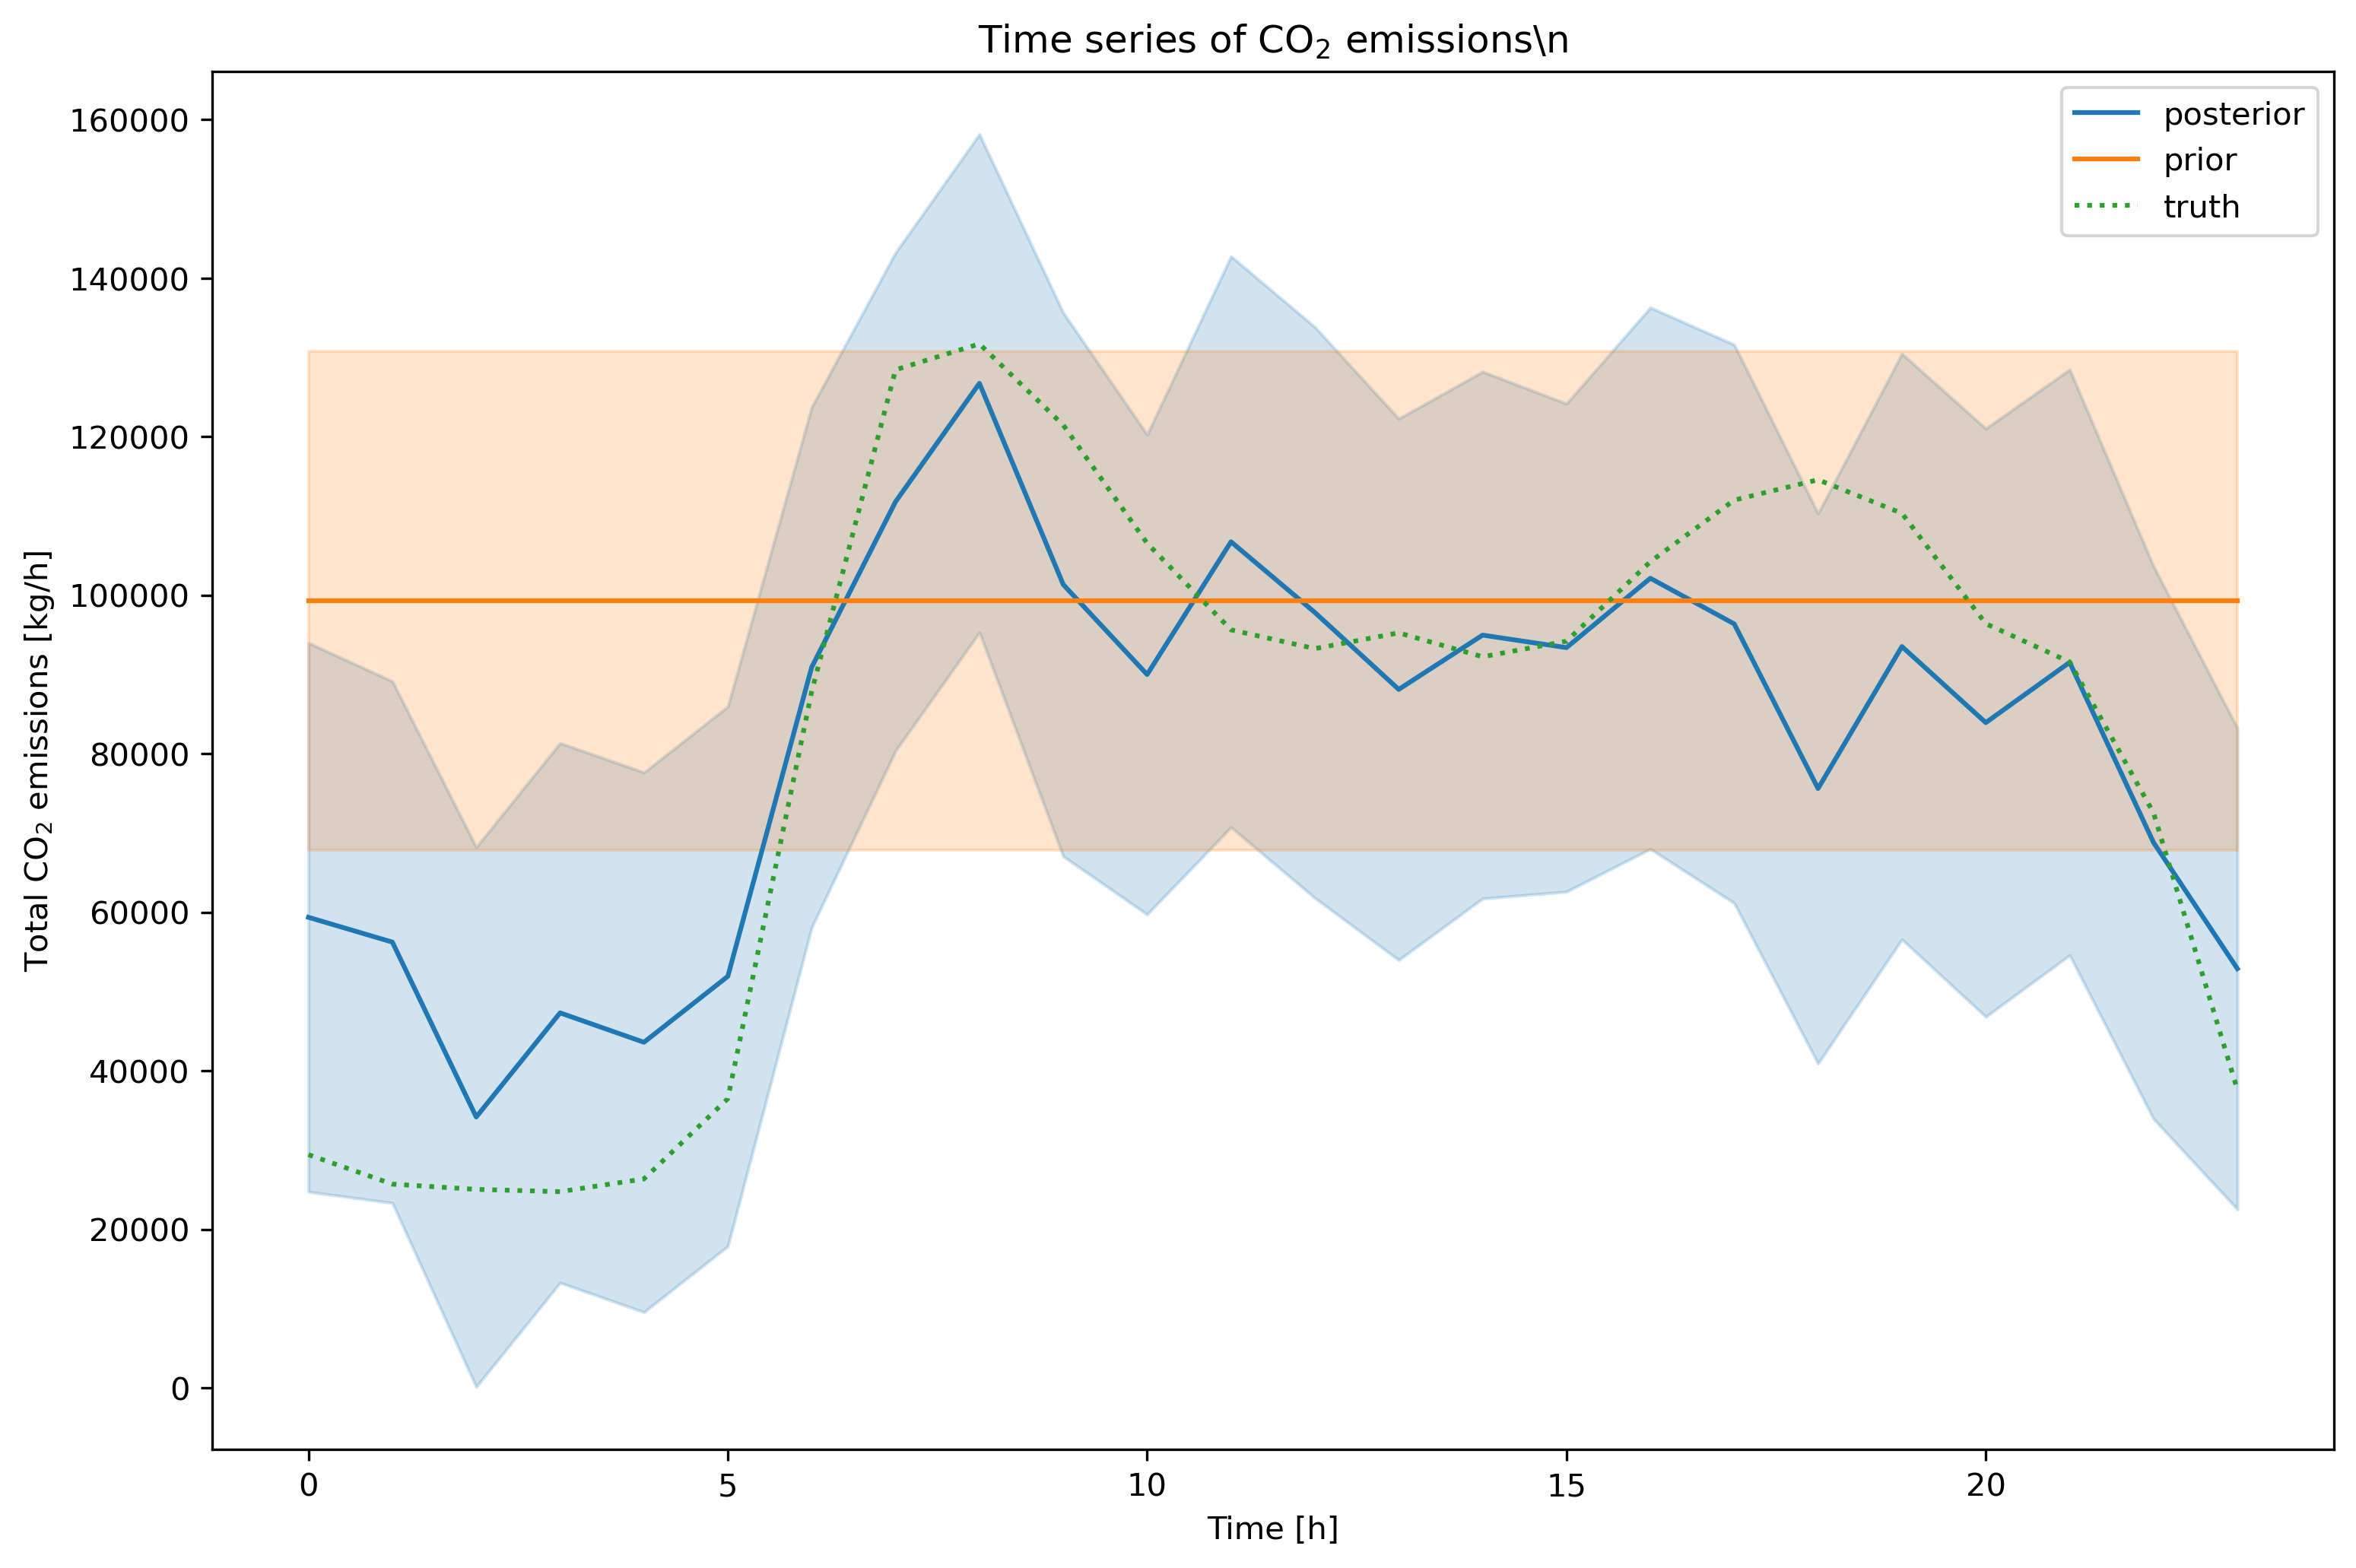

In [77]:
plt.figure(figsize=(12, 8))
mean = posterior_combined.isel(source_group=slice(1, None)).sum("source_group")
std = np.sqrt(var_combined)
line = plt.plot(mean, "-", label="posterior")[0]
plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2, color=line._color)

mean_prior = exp.emissions.prior_absolute.isel(source_group=slice(1, None)).sum(
    "source_group"
)
std_prior = np.sqrt(
    (
        exp.emissions.prior_variance.isel(source_group=slice(1, None))
        * exp.emissions.get_absolute()[exp.emissions.mask] ** 2
    ).sum("source_group")
)
line = plt.plot(mean_prior, label="prior")[0]
plt.fill_between(
    range(len(mean_prior)),
    mean_prior - std_prior,
    mean_prior + std_prior,
    alpha=0.2,
    color=line._color,
)

plt.plot(
    exp.emissions.truth_absolute.isel(source_group=slice(1, None)).sum("source_group"),
    ":",
    label="truth",
)
plt.legend()
print((mean - mean_prior).mean())
plt.title(r"Time series of CO$_2$ emissions\n")
plt.xlabel(r"Time [h]")
plt.ylabel(r"Total CO$_2$ emissions [kg/h]")
plt.savefig("/home/rmaiwald/results/preliminary/more_trace_gases_timeseries")